<a href="https://colab.research.google.com/github/Refactory-Capstone-Project/Loan-default-prediction-challenge-/blob/main/LoanPredictionSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install pandas-profiling xgboost gradio


In [90]:
!pip install --upgrade pandas
!pip install category_encoders


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from huggingface_hub import HfApi, HfFolder, Repository
from category_encoders import TargetEncoder


Import the csv files directly from Github repository

In [92]:
!wget https://github.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/raw/main/Loan_Prediction.zip

--2024-05-29 12:03:16--  https://github.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/raw/main/Loan_Prediction.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/main/Loan_Prediction.zip [following]
--2024-05-29 12:03:16--  https://raw.githubusercontent.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/main/Loan_Prediction.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627991 (1.6M) [application/zip]
Saving to: ‘Loan_Prediction.zip.1’

Loan_Prediction.zip 100%[===================>]   1.55M  -

In [93]:
!unzip /content/Loan_Prediction.zip

Archive:  /content/Loan_Prediction.zip
replace SampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Exploratory Data Analysis for the csv files that will be used for training the models.

# Demographic data (traindemographics.csv)

In [94]:
train_demo = pd.read_csv("/content/traindemographics.csv")
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [95]:
train_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


Check for duplicates and drop them if any

In [96]:
train_demo[train_demo['customerid'].duplicated(keep=False)].sort_values('customerid')

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
1414,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
1928,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
445,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1090,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1996,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
1520,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
272,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
517,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
4126,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN
3021,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN


In [97]:
train_demo = train_demo.drop_duplicates(subset='customerid', keep='first', inplace=False)

Convert the birthdate column to datetime and split it into year, month, day

In [98]:
train_demo['birthdate'] = pd.to_datetime(train_demo['birthdate'])
train_demo['birth_year'] = train_demo['birthdate'].dt.year
train_demo['birth_month'] = train_demo['birthdate'].dt.month
train_demo['birth_day'] = train_demo['birthdate'].dt.day

<ipython-input-98-7e4afb839206>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_demo['birthdate'] = pd.to_datetime(train_demo['birthdate'])
<ipython-input-98-7e4afb839206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_demo['birth_year'] = train_demo['birthdate'].dt.year
<ipython-input-98-7e4afb839206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Encode the values in the bank_account_type column

In [99]:
train_demo['bank_account_type'].value_counts()

bank_account_type
Savings    3414
Other       864
Current      56
Name: count, dtype: int64

In [100]:
encoder = LabelEncoder()
train_demo['bank_account_type'] = encoder.fit_transform(train_demo['bank_account_type'])
train_demo[['bank_account_type']]

,bank_account_type
0,2
1,2
2,2
3,2
4,2
...,...
4341,1
4342,2
4343,2
4344,2


The longitude and latitude columns have a lot of outliers which can be handles by replacing with zero

In [101]:
train_demo['longitude_gps'].describe()


count    4334.000000
mean        4.624000
std         7.194031
min      -118.247009
25%         3.354857
50%         3.591668
75%         6.543691
max       151.209290
Name: longitude_gps, dtype: float64

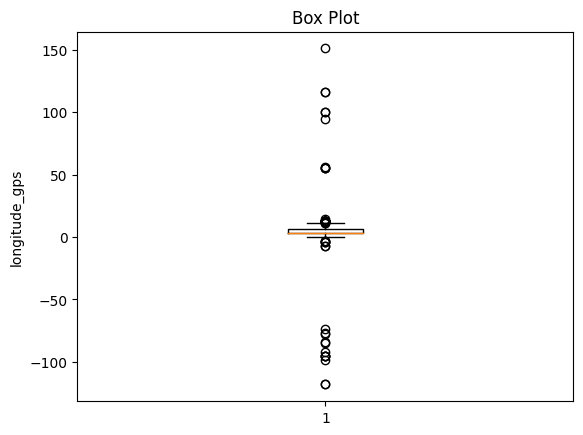

In [102]:
train_demo['longitude_gps'] = train_demo['longitude_gps'].astype(float)
plt.boxplot(train_demo['longitude_gps'])
plt.title('Box Plot')
plt.ylabel('longitude_gps')
plt.show()

The Box plot shows the column has many outliers and they can be replaced with zero

In [103]:
train_demo["longitude_gps"] = train_demo["longitude_gps"] \
                                .where(train_demo["longitude_gps"] < 20)\
                                .where(train_demo["longitude_gps"] > -20)

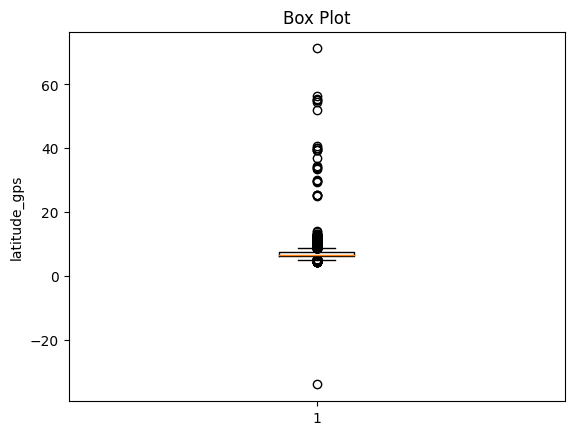

In [104]:
train_demo['latitude_gps'] = train_demo['latitude_gps'].astype(float)
plt.boxplot(train_demo['latitude_gps'])
plt.title('Box Plot')
plt.ylabel('latitude_gps')
plt.show()

In [105]:
train_demo["latitude_gps"] = train_demo["latitude_gps"] \
                                .where(train_demo["latitude_gps"] < 20)\
                                .where(train_demo["latitude_gps"] > -20)

Encode the values in the bank_name_clients column

In [106]:
train_demo["bank_name_clients"].value_counts()

bank_name_clients
GT Bank               1594
First Bank             588
Access Bank            431
UBA                    351
Zenith Bank            301
Diamond Bank           282
EcoBank                150
Stanbic IBTC           144
FCMB                   121
Fidelity Bank          103
Skye Bank              101
Sterling Bank           54
Wema Bank               28
Union Bank              23
Heritage Bank           22
Keystone Bank           19
Standard Chartered      15
Unity Bank               7
Name: count, dtype: int64

In [107]:
encoder = LabelEncoder()
train_demo['bank_name_clients'] = encoder.fit_transform(train_demo['bank_name_clients'])
train_demo[['bank_name_clients']]

,bank_name_clients
0,6
1,12
2,4
3,6
4,6
...,...
4341,10
4342,6
4343,6
4344,6


In [108]:
train_demo['bank_branch_clients'].isnull().sum()

4283

The bank_branch_clients column has so many null values which is an indication that it will not affect the outcome of the model and can be dropped

In [109]:
train_demo.drop(columns=['bank_branch_clients'], inplace=True)

In [110]:
train_demo['employment_status_clients'].isnull().value_counts()

employment_status_clients
False    3686
True      648
Name: count, dtype: int64

There are 648 null values however dropping them will get rid of important data. The null values can be replaced by "Unknown"

In [111]:
train_demo["employment_status_clients"]= train_demo["employment_status_clients"].fillna("Unknown")
train_demo["employment_status_clients"].value_counts()

employment_status_clients
Permanent        3134
Unknown           648
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: count, dtype: int64

In [112]:
train_demo["level_of_education_clients"].isnull().value_counts()

level_of_education_clients
True     3748
False     586
Name: count, dtype: int64

In [113]:
train_demo["level_of_education_clients"]= train_demo["level_of_education_clients"].fillna("Unknown")
train_demo["level_of_education_clients"].value_counts()

level_of_education_clients
Unknown          3748
Graduate          420
Secondary          88
Post-Graduate      68
Primary            10
Name: count, dtype: int64

In [114]:
train_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334 entries, 0 to 4345
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4334 non-null   object        
 1   birthdate                   4334 non-null   datetime64[ns]
 2   bank_account_type           4334 non-null   int64         
 3   longitude_gps               4311 non-null   float64       
 4   latitude_gps                4307 non-null   float64       
 5   bank_name_clients           4334 non-null   int64         
 6   employment_status_clients   4334 non-null   object        
 7   level_of_education_clients  4334 non-null   object        
 8   birth_year                  4334 non-null   int32         
 9   birth_month                 4334 non-null   int32         
 10  birth_day                   4334 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(2), object(

In [115]:
#demo_report = ProfileReport(train_demo)
#demo_report

# Performance data (trainperf.csv)

This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer

In [116]:
train_perf = pd.read_csv('/content/trainperf.csv')
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [117]:
train_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [118]:
train_perf['customerid'].duplicated().sum()

0

In [119]:
train_perf['approveddate'] = pd.to_datetime(train_perf['approveddate'])

train_perf.dtypes

customerid               object
systemloanid              int64
loannumber                int64
approveddate     datetime64[ns]
creationdate             object
loanamount              float64
totaldue                float64
termdays                  int64
referredby               object
good_bad_flag            object
dtype: object

In [120]:
train_perf['creationdate'] = pd.to_datetime(train_perf['creationdate'])
train_perf.dtypes

customerid               object
systemloanid              int64
loannumber                int64
approveddate     datetime64[ns]
creationdate     datetime64[ns]
loanamount              float64
totaldue                float64
termdays                  int64
referredby               object
good_bad_flag            object
dtype: object

referredby column has null values and will need to be cleaned

In [121]:
train_perf['referredby'].isnull().value_counts()

referredby
True     3781
False     587
Name: count, dtype: int64

In [122]:
train_perf["referredby"]= train_perf["referredby"].fillna("Unknown")
train_perf["referredby"].value_counts()

referredby
Unknown                             3781
8a858fc55b2548dd015b286e452c678c       8
8a858f965bb63a25015bc2ddf2577416       3
8a858eeb5bb559d3015bb57fa13f10de       3
8a858e125b391784015b395fa56243e6       3
                                    ... 
8a858e3d5c3b5122015c43f776bd4a3a       1
8a858f7a5b39a003015b39ca67ab2efb       1
8a858fa359d61dae0159d698bf503d29       1
8a858e6f5cd5e874015ce084c86e2a87       1
8a858eda5c8863ff015c9dead65807bb       1
Name: count, Length: 522, dtype: int64

In [123]:
train_perf["good_bad_flag"].value_counts()

good_bad_flag
Good    3416
Bad      952
Name: count, dtype: int64

In [124]:
encoder = LabelEncoder()
train_perf['good_bad_flag'] = encoder.fit_transform(train_perf['good_bad_flag'])
train_perf[['good_bad_flag']]

,good_bad_flag
0,1
1,1
2,1
3,1
4,1
...,...
4363,0
4364,0
4365,0
4366,0


In [125]:
train_perf.head(5)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,Unknown,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,Unknown,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,Unknown,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,Unknown,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,Unknown,1


In [126]:
#performance_report = ProfileReport(train_perf)
#performance_report

# Previous loans data (trainprevloans.csv)

This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

In [127]:
train_prevloans = pd.read_csv('/content/trainprevloans.csv')
train_prevloans.head(5)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [128]:
train_prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [129]:
train_prevloans[train_prevloans['customerid'].duplicated(keep=False)].sort_values('customerid')

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
16602,8a1a1e7e4f707f8b014f797718316cad,301947045,4,2017-06-21 22:09:51.000000,2017-06-21 21:09:44.000000,30000.0,39000.0,60,2017-07-26 19:48:11.000000,NaN,2017-07-21 00:00:00.000000,2017-07-20 15:05:33.000000
5216,8a1a1e7e4f707f8b014f797718316cad,301620412,1,2016-05-13 15:29:37.000000,2016-05-13 14:29:31.000000,10000.0,13000.0,30,2016-06-15 00:03:33.000000,NaN,2016-06-13 00:00:00.000000,2016-06-14 10:41:13.000000
17546,8a1a1e7e4f707f8b014f797718316cad,301632940,2,2016-06-15 11:22:38.000000,2016-06-15 10:22:32.000000,10000.0,13000.0,30,2016-07-15 13:59:02.000000,NaN,2016-07-15 00:00:00.000000,2016-07-15 13:43:58.000000
7999,8a1a1e7e4f707f8b014f797718316cad,301916386,3,2017-05-23 14:21:42.000000,2017-05-23 13:20:30.000000,20000.0,24500.0,30,2017-06-21 21:58:00.000000,NaN,2017-06-22 00:00:00.000000,2017-06-21 21:47:51.000000
12199,8a1a32fc49b632520149c3b8fdf85139,301937031,7,2017-06-13 11:02:36.000000,2017-06-13 10:01:27.000000,20000.0,24500.0,30,2017-07-13 18:45:26.000000,NaN,2017-07-13 00:00:00.000000,2017-07-13 18:35:18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
18111,8a858fff5a36fe68015a3b8dcb8a3843,301852396,3,2017-04-02 13:49:34.000000,2017-04-02 12:49:27.000000,10000.0,11500.0,15,2017-04-17 13:03:52.000000,NaN,2017-04-17 00:00:00.000000,2017-04-17 12:48:43.000000
7549,8a858fff5a36fe68015a3b8dcb8a3843,301951448,6,2017-06-25 15:51:04.000000,2017-06-25 14:50:57.000000,20000.0,24500.0,30,2017-07-23 15:31:42.000000,NaN,2017-07-25 00:00:00.000000,2017-07-23 15:21:33.000000
10005,8a858fff5a36fe68015a3b8dcb8a3843,301873835,4,2017-04-19 20:22:37.000000,2017-04-19 19:22:30.000000,10000.0,11450.0,15,2017-04-21 21:45:31.000000,NaN,2017-05-04 00:00:00.000000,2017-04-21 21:30:22.000000
7550,8a858fff5a36fe68015a3b8dcb8a3843,301830401,2,2017-03-03 07:16:35.000000,2017-03-03 06:16:15.000000,10000.0,13000.0,30,2017-04-02 00:16:27.000000,NaN,2017-04-03 00:00:00.000000,2017-04-02 00:01:17.000000


In [130]:
train_prevloans = train_prevloans.drop_duplicates(subset='customerid', keep='first', inplace=False)

In [131]:
train_prevloans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4359 entries, 0 to 18181
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       4359 non-null   object 
 1   systemloanid     4359 non-null   int64  
 2   loannumber       4359 non-null   int64  
 3   approveddate     4359 non-null   object 
 4   creationdate     4359 non-null   object 
 5   loanamount       4359 non-null   float64
 6   totaldue         4359 non-null   float64
 7   termdays         4359 non-null   int64  
 8   closeddate       4359 non-null   object 
 9   referredby       587 non-null    object 
 10  firstduedate     4359 non-null   object 
 11  firstrepaiddate  4359 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 442.7+ KB


In [132]:
train_prevloans['approveddate'] =pd.to_datetime(train_prevloans['approveddate'])
train_prevloans['creationdate'] =pd.to_datetime(train_prevloans['creationdate'])
train_prevloans['firstduedate'] =pd.to_datetime(train_prevloans['firstduedate'])
train_prevloans['firstrepaiddate'] =pd.to_datetime(train_prevloans['firstrepaiddate'])
train_prevloans['closeddate'] =pd.to_datetime(train_prevloans['closeddate'])
train_prevloans.dtypes

<ipython-input-132-63986480351d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prevloans['approveddate'] =pd.to_datetime(train_prevloans['approveddate'])
<ipython-input-132-63986480351d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prevloans['creationdate'] =pd.to_datetime(train_prevloans['creationdate'])
<ipython-input-132-63986480351d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

customerid                 object
systemloanid                int64
loannumber                  int64
approveddate       datetime64[ns]
creationdate       datetime64[ns]
loanamount                float64
totaldue                  float64
termdays                    int64
closeddate         datetime64[ns]
referredby                 object
firstduedate       datetime64[ns]
firstrepaiddate    datetime64[ns]
dtype: object

In [133]:
train_prevloans['referredby'].isnull().value_counts()

referredby
True     3772
False     587
Name: count, dtype: int64

In [134]:
train_prevloans["referredby"]= train_prevloans["referredby"].fillna("Unknown")
train_prevloans["referredby"].value_counts()

referredby
Unknown                             3772
8a858fc55b2548dd015b286e452c678c       8
8a858f965bb63a25015bc2ddf2577416       3
8a858eeb5bb559d3015bb57fa13f10de       3
8a858e125b391784015b395fa56243e6       3
                                    ... 
8a858ee65be8d42d015be8ed0ebb0f5f       1
8a858eda552adcc2015548f0eb523fc3       1
8a858f2c585375f00158688cf76b3db7       1
8a858f305cb1ec4e015cc41c66eb41b8       1
8a858eaa55a0b8ae0155ad2cab5e49cc       1
Name: count, Length: 522, dtype: int64

In [135]:
#prevloan_report = ProfileReport(train_prevloans)
#prevloan_report

# It would be wise to merge the CSV files since each contains relevant information for loan prediction.

In [136]:
merged_train_data = train_demo.merge(train_perf, on='customerid')
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  3269 non-null   object        
 1   birthdate                   3269 non-null   datetime64[ns]
 2   bank_account_type           3269 non-null   int64         
 3   longitude_gps               3248 non-null   float64       
 4   latitude_gps                3245 non-null   float64       
 5   bank_name_clients           3269 non-null   int64         
 6   employment_status_clients   3269 non-null   object        
 7   level_of_education_clients  3269 non-null   object        
 8   birth_year                  3269 non-null   int32         
 9   birth_month                 3269 non-null   int32         
 10  birth_day                   3269 non-null   int32         
 11  systemloanid                3269 non-null   int64       

In [137]:
merged_train_data.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'birth_year', 'birth_month', 'birth_day',
       'systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'referredby', 'good_bad_flag'],
      dtype='object')

In [138]:
merged_train_data.duplicated().sum()


0

In [139]:
merged_train_data = merged_train_data.merge(train_prevloans, on='customerid')
merged_train_data.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'birth_year', 'birth_month', 'birth_day',
       'systemloanid_x', 'loannumber_x', 'approveddate_x', 'creationdate_x',
       'loanamount_x', 'totaldue_x', 'termdays_x', 'referredby_x',
       'good_bad_flag', 'systemloanid_y', 'loannumber_y', 'approveddate_y',
       'creationdate_y', 'loanamount_y', 'totaldue_y', 'termdays_y',
       'closeddate', 'referredby_y', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [140]:
merged_train_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,birth_year,birth_month,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,2,3.319219,6.528604,6,Unknown,Unknown,1973,10,...,1,2017-06-19 17:55:26,2017-06-19 16:54:19,10000.0,11500.0,15,2017-07-04 18:09:47,8a858899538ddb8e0153a780c56e34bb,2017-07-05,2017-07-04 17:59:36
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,2,3.325598,7.119403,12,Permanent,Unknown,1986,1,...,1,2017-06-07 12:47:30,2017-06-07 11:46:22,10000.0,13000.0,30,2017-07-10 08:52:54,Unknown,2017-07-07,2017-07-10 08:42:44
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,2,5.746100,5.563174,4,Unknown,Unknown,1987,4,...,3,2017-06-08 11:49:34,2017-06-08 10:49:27,10000.0,13000.0,30,2017-07-11 10:12:20,Unknown,2017-07-10,2017-07-11 10:02:11
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,2,3.362850,6.642485,6,Permanent,Unknown,1991,7,...,1,2017-06-15 14:05:26,2017-06-15 13:04:18,10000.0,11500.0,15,2017-07-18 19:24:13,Unknown,2017-06-30,2017-07-18 19:14:05
4,8a858ea05a859123015a8892914d15b7,1990-07-21,2,3.365935,6.564823,0,Permanent,Unknown,1990,7,...,3,2017-04-21 21:59:19,2017-04-21 20:59:13,10000.0,13000.0,30,2017-05-22 22:45:02,Unknown,2017-05-22,2017-05-22 22:29:52


# Merge the test data

In [141]:
test_demo = pd.read_csv("/content/testdemographics.csv")
test_demo

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN
...,...,...,...,...,...,...,...,...,...
1482,8a858fc25bafabdc015bb47fda0323e5,1976-04-13 00:00:00.000000,Savings,3.481190,6.442728,GT Bank,NaN,Permanent,NaN
1483,8a858e245c214660015c3397e4db389a,1990-10-24 00:00:00.000000,Savings,4.738209,8.179723,GT Bank,NaN,Permanent,NaN
1484,8a858e8b5bc9e7e6015bcd7374077f0c,1988-06-12 00:00:00.000000,Savings,3.424825,6.455802,First Bank,NaN,Permanent,NaN
1485,8a858f2e5c699f3a015c77aa22ed7f23,1974-03-23 00:00:00.000000,Savings,3.318851,7.113212,FCMB,NaN,Permanent,NaN


In [142]:
test_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  1487 non-null   object 
 1   birthdate                   1487 non-null   object 
 2   bank_account_type           1487 non-null   object 
 3   longitude_gps               1487 non-null   float64
 4   latitude_gps                1487 non-null   float64
 5   bank_name_clients           1487 non-null   object 
 6   bank_branch_clients         14 non-null     object 
 7   employment_status_clients   1270 non-null   object 
 8   level_of_education_clients  210 non-null    object 
dtypes: float64(2), object(7)
memory usage: 104.7+ KB


In [143]:
test_demo[test_demo['customerid'].duplicated(keep=False)].sort_values('customerid')

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
497,8a8588b75438f49901544510041e0951,1980-01-16 00:00:00.000000,Other,3.342808,6.542411,Zenith Bank,NaN,Permanent,Graduate
502,8a8588b75438f49901544510041e0951,1980-01-16 00:00:00.000000,Other,3.342808,6.542411,Zenith Bank,NaN,Permanent,Graduate
248,8a858e885b68546c015b7238f22027ba,1975-06-18 00:00:00.000000,Savings,3.353123,6.587837,First Bank,NaN,Permanent,NaN
810,8a858e885b68546c015b7238f22027ba,1975-06-18 00:00:00.000000,Savings,3.353123,6.587837,First Bank,NaN,Permanent,NaN
1252,8a858f2e5c699f3a015c6e10b65607c9,1978-06-20 00:00:00.000000,Savings,3.325513,6.500937,GT Bank,NaN,Permanent,NaN
1285,8a858f2e5c699f3a015c6e10b65607c9,1978-06-20 00:00:00.000000,Savings,3.325513,6.500937,GT Bank,NaN,Permanent,NaN


In [144]:
test_demo = test_demo.drop_duplicates(subset='customerid', keep='first', inplace=False)

In [145]:
test_demo['birthdate'] = pd.to_datetime(test_demo['birthdate'])
test_demo['birth_year'] = test_demo['birthdate'].dt.year
test_demo['birth_month'] = test_demo['birthdate'].dt.month
test_demo['birth_day'] = test_demo['birthdate'].dt.day

<ipython-input-145-17f1d9622cc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['birthdate'] = pd.to_datetime(test_demo['birthdate'])
<ipython-input-145-17f1d9622cc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['birth_year'] = test_demo['birthdate'].dt.year
<ipython-input-145-17f1d9622cc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [146]:
test_demo['bank_account_type'].value_counts()

bank_account_type
Savings    1156
Other       304
Current      24
Name: count, dtype: int64

In [147]:
encoder = LabelEncoder()
test_demo['bank_name_clients'] = encoder.fit_transform(test_demo['bank_name_clients'])
test_demo[['bank_name_clients']]

<ipython-input-147-74765b1b39af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['bank_name_clients'] = encoder.fit_transform(test_demo['bank_name_clients'])


,bank_name_clients
0,7
1,13
2,5
3,13
4,5
...,...
1482,6
1483,6
1484,5
1485,3


In [148]:
encoder = LabelEncoder()
test_demo['bank_account_type'] = encoder.fit_transform(test_demo['bank_account_type'])
test_demo[['bank_account_type']]

<ipython-input-148-4feea847e1c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['bank_account_type'] = encoder.fit_transform(test_demo['bank_account_type'])


,bank_account_type
0,2
1,2
2,2
3,2
4,2
...,...
1482,2
1483,2
1484,2
1485,2


In [149]:
test_demo['longitude_gps'].describe()

count    1484.000000
mean        4.435911
std         6.328801
min      -149.033700
25%         3.355806
50%         3.585199
75%         6.563910
max        39.815590
Name: longitude_gps, dtype: float64

<ipython-input-150-5340bbddd28f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['longitude_gps'] = test_demo['longitude_gps'].astype(float)


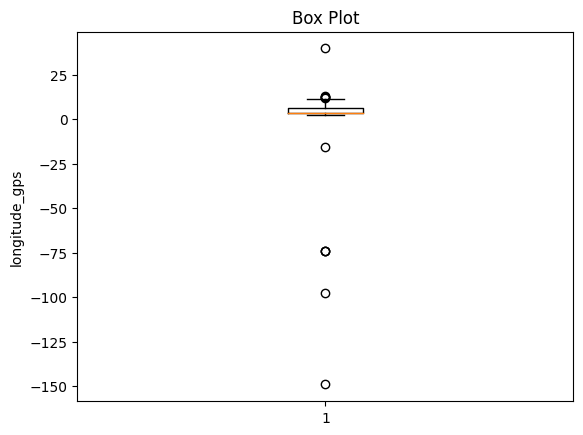

In [150]:
test_demo['longitude_gps'] = test_demo['longitude_gps'].astype(float)
plt.boxplot(test_demo['longitude_gps'])
plt.title('Box Plot')
plt.ylabel('longitude_gps')
plt.show()

In [151]:
test_demo["longitude_gps"] = test_demo["longitude_gps"] \
                                .where(test_demo["longitude_gps"] < 20)\
                                .where(test_demo["longitude_gps"] > -20)

<ipython-input-151-21b2578545ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo["longitude_gps"] = test_demo["longitude_gps"] \


In [152]:
test_demo['latitude_gps'].describe()

count    1484.000000
mean        7.135858
std         3.018973
min       -74.005974
25%         6.480171
50%         6.620257
75%         7.433745
max        40.895322
Name: latitude_gps, dtype: float64

<ipython-input-153-056f8ca95c97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo['latitude_gps'] = test_demo['latitude_gps'].astype(float)


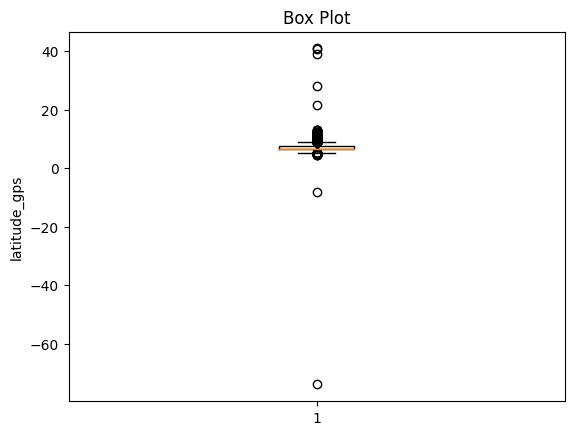

In [153]:
test_demo['latitude_gps'] = test_demo['latitude_gps'].astype(float)
plt.boxplot(test_demo['latitude_gps'])
plt.title('Box Plot')
plt.ylabel('latitude_gps')
plt.show()

In [154]:
test_demo["latitude_gps"] = test_demo["latitude_gps"] \
                                .where(test_demo["latitude_gps"] < 20)\
                                .where(test_demo["latitude_gps"] > -20)

<ipython-input-154-f31b61cc8d29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo["latitude_gps"] = test_demo["latitude_gps"] \


In [155]:
test_demo.drop(columns=['bank_branch_clients'], inplace=True)

<ipython-input-155-b3787091c17f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo.drop(columns=['bank_branch_clients'], inplace=True)


In [156]:
test_demo['employment_status_clients'].isnull().value_counts()

employment_status_clients
False    1267
True      217
Name: count, dtype: int64

In [157]:
test_demo["employment_status_clients"]= test_demo["employment_status_clients"].fillna("Unknown")
test_demo["employment_status_clients"].value_counts()

<ipython-input-157-8d4825d2b0ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo["employment_status_clients"]= test_demo["employment_status_clients"].fillna("Unknown")


employment_status_clients
Permanent        1071
Unknown           217
Self-Employed     122
Student            47
Unemployed         22
Retired             4
Contract            1
Name: count, dtype: int64

In [158]:
test_demo["level_of_education_clients"].isnull().value_counts()

level_of_education_clients
True     1275
False     209
Name: count, dtype: int64

In [159]:
test_demo["level_of_education_clients"]= test_demo["level_of_education_clients"].fillna("Unknown")
test_demo["level_of_education_clients"].value_counts()

<ipython-input-159-52fefa4b0957>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_demo["level_of_education_clients"]= test_demo["level_of_education_clients"].fillna("Unknown")


level_of_education_clients
Unknown          1275
Graduate          156
Secondary          30
Post-Graduate      22
Primary             1
Name: count, dtype: int64

In [160]:
test_prevloans = pd.read_csv("/content/testprevloans.csv")
test_prevloans

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5902,8a858f085b494826015b54a0b2a1093b,301861709,1,2017-04-09 23:04:32.000000,2017-04-09 22:04:10.000000,10000.0,13000.0,30,2017-05-02 22:27:03.000000,8a858e4f5929c3df0159420645f46f55,2017-05-09 00:00:00.000000,2017-05-02 22:11:54.000000
5903,8a858f565b683b56015b7391c2617960,301869817,1,2017-04-15 23:33:17.000000,2017-04-15 22:33:05.000000,10000.0,11500.0,15,2017-04-25 19:32:42.000000,NaN,2017-05-02 00:00:00.000000,2017-04-25 19:17:33.000000
5904,8a858fab5b9105dc015b975e594e394a,301952446,1,2017-06-26 15:46:28.000000,2017-06-26 14:45:20.000000,10000.0,13000.0,30,2017-07-13 13:12:43.000000,NaN,2017-07-26 00:00:00.000000,2017-07-13 13:02:34.000000
5905,8a858fcf5b39c3ba015b39c7691603e1,301887884,2,2017-05-03 06:56:10.000000,2017-05-03 05:56:04.000000,10000.0,13000.0,30,2017-06-01 22:00:17.000000,NaN,2017-06-02 00:00:00.000000,2017-06-01 21:50:07.000000


In [161]:
test_prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       5907 non-null   object 
 1   systemloanid     5907 non-null   int64  
 2   loannumber       5907 non-null   int64  
 3   approveddate     5907 non-null   object 
 4   creationdate     5907 non-null   object 
 5   loanamount       5907 non-null   float64
 6   totaldue         5907 non-null   float64
 7   termdays         5907 non-null   int64  
 8   closeddate       5907 non-null   object 
 9   referredby       325 non-null    object 
 10  firstduedate     5907 non-null   object 
 11  firstrepaiddate  5907 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 553.9+ KB


In [162]:
test_prevloans[test_prevloans['customerid'].duplicated(keep=False)].sort_values('customerid')

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
3759,8a28afc7474813a40147639ec637156b,301806551,5,2017-01-30 19:42:34.000000,2017-01-30 18:42:27.000000,20000.0,23600.0,30,2017-02-25 14:20:57.000000,NaN,2017-03-01 00:00:00.000000,2017-02-25 14:05:46.000000
3758,8a28afc7474813a40147639ec637156b,301630942,1,2016-06-10 16:53:11.000000,2016-06-10 15:53:05.000000,10000.0,11500.0,15,2016-06-27 13:41:16.000000,NaN,2016-06-27 00:00:00.000000,2016-06-27 13:26:13.000000
2774,8a28afc7474813a40147639ec637156b,301958022,10,2017-06-30 16:57:17.000000,2017-06-30 15:57:11.000000,15000.0,16500.0,30,2017-07-26 09:11:44.000000,NaN,2017-07-31 00:00:00.000000,2017-07-26 09:01:34.000000
2283,8a28afc7474813a40147639ec637156b,301918837,9,2017-05-26 13:06:26.000000,2017-05-26 12:06:19.000000,30000.0,36000.0,60,2017-06-28 14:40:14.000000,NaN,2017-06-28 00:00:00.000000,2017-06-28 14:30:05.000000
2284,8a28afc7474813a40147639ec637156b,301662726,3,2016-07-28 15:10:21.000000,2016-07-28 14:09:25.000000,8000.0,10400.0,30,2016-08-26 18:26:05.000000,NaN,2016-08-29 00:00:00.000000,2016-08-26 18:11:02.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2954,8aab160f499477da014999ba2f0f578b,301629153,2,2016-06-07 10:08:48.000000,2016-06-07 09:08:42.000000,10000.0,11500.0,15,2016-06-21 00:05:38.000000,NaN,2016-06-22 00:00:00.000000,2016-06-20 12:36:02.000000
3386,8addcb0645aff34b0145b25fe1616ee0,301906743,2,2017-05-14 21:40:44.000000,2017-05-14 20:40:38.000000,10000.0,11500.0,15,2017-05-15 07:12:54.000000,NaN,2017-05-30 00:00:00.000000,2017-05-15 06:57:44.000000
3277,8addcb0645aff34b0145b25fe1616ee0,301890465,1,2017-05-05 00:22:05.000000,2017-05-04 23:21:33.000000,10000.0,11500.0,15,2017-05-13 07:47:31.000000,NaN,2017-05-22 00:00:00.000000,2017-05-13 07:32:22.000000
4808,8addcb0645aff34b0145b25fe1616ee0,301954796,4,2017-06-28 14:03:05.000000,2017-06-28 13:02:58.000000,10000.0,12250.0,30,2017-07-26 12:54:23.000000,NaN,2017-07-28 00:00:00.000000,2017-07-26 12:44:14.000000


In [163]:
test_prevloans = test_prevloans.drop_duplicates(subset='customerid', keep='first', inplace=False)

In [164]:
test_prevloans['approveddate'] =pd.to_datetime(test_prevloans['approveddate'])
test_prevloans['creationdate'] =pd.to_datetime(test_prevloans['creationdate'])
test_prevloans['firstduedate'] =pd.to_datetime(test_prevloans['firstduedate'])
test_prevloans['firstrepaiddate'] =pd.to_datetime(test_prevloans['firstrepaiddate'])
test_prevloans['closeddate'] =pd.to_datetime(test_prevloans['closeddate'])


<ipython-input-164-31963ec9210d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prevloans['approveddate'] =pd.to_datetime(test_prevloans['approveddate'])
<ipython-input-164-31963ec9210d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prevloans['creationdate'] =pd.to_datetime(test_prevloans['creationdate'])
<ipython-input-164-31963ec9210d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [165]:
test_prevloans['referredby'].isnull().value_counts()

referredby
True     1260
False     182
Name: count, dtype: int64

In [166]:
test_prevloans["referredby"]= test_prevloans["referredby"].fillna("Unknown")
test_prevloans["referredby"].value_counts()

<ipython-input-166-f28ba5e5f6fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prevloans["referredby"]= test_prevloans["referredby"].fillna("Unknown")


referredby
Unknown                             1260
8a858ee0560bc07701561585ea777a43       2
8a858fc15b68ba6a015b6d46f82b05f9       2
8a858eb25b5d2e82015b5d35c1bb094d       2
8a858edb552adcfd015546aebb4f0717       2
                                    ... 
8a858fa154e2912f0154ee239b0857f0       1
8a858e69566ae5b801566fe7f69c7fad       1
8a858fd3552c756201553f67a27117ef       1
8a858fbf5b3a0b46015b3c94f74316e8       1
8a858e8a5c1c14b8015c20ef0e5e1da8       1
Name: count, Length: 177, dtype: int64

In [167]:
test_perf = pd.read_csv("/content/testperf.csv")
test_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [168]:
test_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customerid    1450 non-null   object 
 1   systemloanid  1450 non-null   int64  
 2   loannumber    1450 non-null   int64  
 3   approveddate  1450 non-null   object 
 4   creationdate  1450 non-null   object 
 5   loanamount    1450 non-null   int64  
 6   totaldue      1450 non-null   float64
 7   termdays      1450 non-null   int64  
 8   referredby    184 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 102.1+ KB


In [169]:
test_perf['customerid'].duplicated().sum()

0

In [170]:
test_perf["referredby"]= test_perf["referredby"].fillna("Unknown")
test_perf["referredby"].value_counts()

referredby
Unknown                             1266
8a858fc15b68ba6a015b6d46f82b05f9       2
8a858f5b5bee1b11015bee3c86711191       2
8a858edb552adcfd015546aebb4f0717       2
8a858f385b34d285015b368d23720716       2
                                    ... 
8a858f455b5d1896015b5d192a1d0090       1
8a858fca5c35df2c015c393bc8e00879       1
8a858f275c451af5015c54543f824e92       1
8a858f1b5b256bc9015b2f998c4d6822       1
8a858ff259d1429e0159d2d0194c4b8e       1
Name: count, Length: 179, dtype: int64

In [171]:
merged_test_data = test_demo.merge(test_perf, on='customerid')
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  385 non-null    object        
 1   birthdate                   385 non-null    datetime64[ns]
 2   bank_account_type           385 non-null    int64         
 3   longitude_gps               382 non-null    float64       
 4   latitude_gps                382 non-null    float64       
 5   bank_name_clients           385 non-null    int64         
 6   employment_status_clients   385 non-null    object        
 7   level_of_education_clients  385 non-null    object        
 8   birth_year                  385 non-null    int32         
 9   birth_month                 385 non-null    int32         
 10  birth_day                   385 non-null    int32         
 11  systemloanid                385 non-null    int64         

In [172]:
merged_test_data = merged_test_data.merge(test_prevloans, on='customerid')
merged_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  384 non-null    object        
 1   birthdate                   384 non-null    datetime64[ns]
 2   bank_account_type           384 non-null    int64         
 3   longitude_gps               381 non-null    float64       
 4   latitude_gps                381 non-null    float64       
 5   bank_name_clients           384 non-null    int64         
 6   employment_status_clients   384 non-null    object        
 7   level_of_education_clients  384 non-null    object        
 8   birth_year                  384 non-null    int32         
 9   birth_month                 384 non-null    int32         
 10  birth_day                   384 non-null    int32         
 11  systemloanid_x              384 non-null    int64         

# Training the models. Three models were used for this project ie Decision tree model, Logistic regression and SVM. The different parameters were used to make sure there's the best possible outcome

In [173]:
# Define parameter grids
dt_param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__random_state': [42]
}

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__max_iter': [100, 200, 300],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__random_state': [42]
}

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__random_state': [42]
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 6, 9]
}


In [174]:
submission_data = pd.read_csv('/content/SampleSubmission.csv')

X_train = merged_train_data.drop(columns=["good_bad_flag"])
y_train = merged_train_data["good_bad_flag"]


# Filter test data to include only the customer IDs present in the submission file
merged_test_data = merged_test_data[merged_test_data['customerid'].isin(submission_data['customerid'])]


X_test = merged_test_data

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['number']).columns


# Preprocessing for numerical data: Impute missing values with the mean, scale the features, log transformation, and add polynomial features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


# Preprocessing for categorical data: Impute missing values with a placeholder and then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



# Decision Tree Model Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Logistic Regression Model Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# SVM Model Pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Perform GridSearchCV for each model
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train_split, y_train_split)

lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
lr_grid_search.fit(X_train_split, y_train_split)

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
svm_grid_search.fit(X_train_split, y_train_split)

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train_split, y_train_split)

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train_split, y_train_split)

# Extract best parameters and scores
best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_

best_lr_params = lr_grid_search.best_params_
best_lr_score = lr_grid_search.best_score_

best_svm_params = svm_grid_search.best_params_
best_svm_score = svm_grid_search.best_score_

best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_

best_xgb_params = xgb_grid_search.best_params_
best_xgb_score = xgb_grid_search.best_score_

print(f"Best Decision Tree Parameters: {best_dt_params}")
print(f"Best Decision Tree Score: {best_dt_score}")

print(f"\nBest Logistic Regression Parameters: {best_lr_params}")
print(f"Best Logistic Regression Score: {best_lr_score}")

print(f"\nBest SVM Parameters: {best_svm_params}")
print(f"Best SVM Score: {best_svm_score}")

print(f"\nBest Random Forest Parameters: {best_rf_params}")
print(f"Best Random Forest Score: {best_rf_score}")

print(f"\nBest XGBoost Parameters: {best_xgb_params}")
print(f"Best XGBoost Score: {best_xgb_score}")

# Choose the best model
best_model = None
best_model_name = ""
best_score = max(best_dt_score, best_lr_score, best_svm_score, best_rf_score, best_xgb_score)
if best_score == best_dt_score:
    best_model = dt_grid_search.best_estimator_
    best_model_name = "Decision Tree"
elif best_score == best_lr_score:
    best_model = lr_grid_search.best_estimator_
    best_model_name = "Logistic Regression"
elif best_score == best_svm_score:
    best_model = svm_grid_search.best_estimator_
    best_model_name = "SVM"
elif best_score == best_rf_score:
    best_model = rf_grid_search.best_estimator_
    best_model_name = "Random Forest"
else:
    best_model = xgb_grid_search.best_estimator_
    best_model_name = "XGBoost"

# Fit the best model on the entire training data
best_model.fit(X_train, y_train)

# Make predictions on the test dataset
test_predictions = best_model.predict(X_test)

test_predictions_df = pd.DataFrame({'customerid': merged_test_data['customerid'], 'Good_Bad_flag': test_predictions})
test_predictions_df.to_csv("test_predictions_df")

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model ({best_model_name}) saved successfully.")


Best Decision Tree Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__random_state': 42}
Best Decision Tree Score: 0.7575547790158458

Best Logistic Regression Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}
Best Logistic Regression Score: 0.7805447499322359

Best SVM Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'classifier__random_state': 42}
Best SVM Score: 0.7832252771001368

Best Random Forest Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best Random Forest Score: 0.7832260096847689

Best XGBoost Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 300}
Best XGBoost Score: 0.7839900954557776
Best model (XGBoost) saved successfully.


In [175]:
submit = pd.concat([submission_data, test_predictions_df], axis=0)
submit.to_csv("submit2.csv", index=False)

In [176]:
!pip install flask
!pip install gunicorn
